#Классификация


Задача - предсказать, будет ли студент успешно трудоустроен. Это актуальная практическая задача. Людям без работы можно будет дополнительно предложить стажировок, курсов, работы, а люди с предсказанием успешного трудоустройства являются перспективными кандидантами.
В такой задаче важно уделить внимание на минимизацию ложноотрицательных ошибки, когда модель предсказала трудоустройство, но студент фактически остался безработный, и на минимизацию ложноположительных ошибок, когда модель предсказала отстутствие работы, но студент всё же трудоустроен.
F1-мера наиболее подходящая метрика для оценка качества моделей. Эта метрика учитывает как ложноположительные, так и ложноотрицательные ошибки, и дает сбалансированную оценку. Она особенно полезна при несбалансированных классах.

##Исследование датасета

Подключение библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка датасета

In [2]:
df = pd.read_csv('placementdata.csv')

Размер датасета

In [3]:
print("Размер датасета:", df.shape)

Размер датасета: (10000, 12)


Первые 5 строк датасета

In [4]:
print(df.head())

   StudentID  CGPA  Internships  Projects  Workshops/Certifications  \
0          1   7.5            1         1                         1   
1          2   8.9            0         3                         2   
2          3   7.3            1         2                         2   
3          4   7.5            1         1                         2   
4          5   8.3            1         2                         2   

   AptitudeTestScore  SoftSkillsRating ExtracurricularActivities  \
0                 65               4.4                        No   
1                 90               4.0                       Yes   
2                 82               4.8                       Yes   
3                 85               4.4                       Yes   
4                 86               4.5                       Yes   

  PlacementTraining  SSC_Marks  HSC_Marks PlacementStatus  
0                No         61         79       NotPlaced  
1               Yes         78         82   

Информация о типах данных и пропусках

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  10000 non-null  int64  
 1   CGPA                       10000 non-null  float64
 2   Internships                10000 non-null  int64  
 3   Projects                   10000 non-null  int64  
 4   Workshops/Certifications   10000 non-null  int64  
 5   AptitudeTestScore          10000 non-null  int64  
 6   SoftSkillsRating           10000 non-null  float64
 7   ExtracurricularActivities  10000 non-null  object 
 8   PlacementTraining          10000 non-null  object 
 9   SSC_Marks                  10000 non-null  int64  
 10  HSC_Marks                  10000 non-null  int64  
 11  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB
None


Статистика по числовым признакам

In [6]:
print(df.describe())

         StudentID          CGPA   Internships      Projects  \
count  10000.00000  10000.000000  10000.000000  10000.000000   
mean    5000.50000      7.698010      1.049200      2.026600   
std     2886.89568      0.640131      0.665901      0.867968   
min        1.00000      6.500000      0.000000      0.000000   
25%     2500.75000      7.400000      1.000000      1.000000   
50%     5000.50000      7.700000      1.000000      2.000000   
75%     7500.25000      8.200000      1.000000      3.000000   
max    10000.00000      9.100000      2.000000      3.000000   

       Workshops/Certifications  AptitudeTestScore  SoftSkillsRating  \
count              10000.000000       10000.000000      10000.000000   
mean                   1.013200          79.449900          4.323960   
std                    0.904272           8.159997          0.411622   
min                    0.000000          60.000000          3.000000   
25%                    0.000000          73.000000          4.0

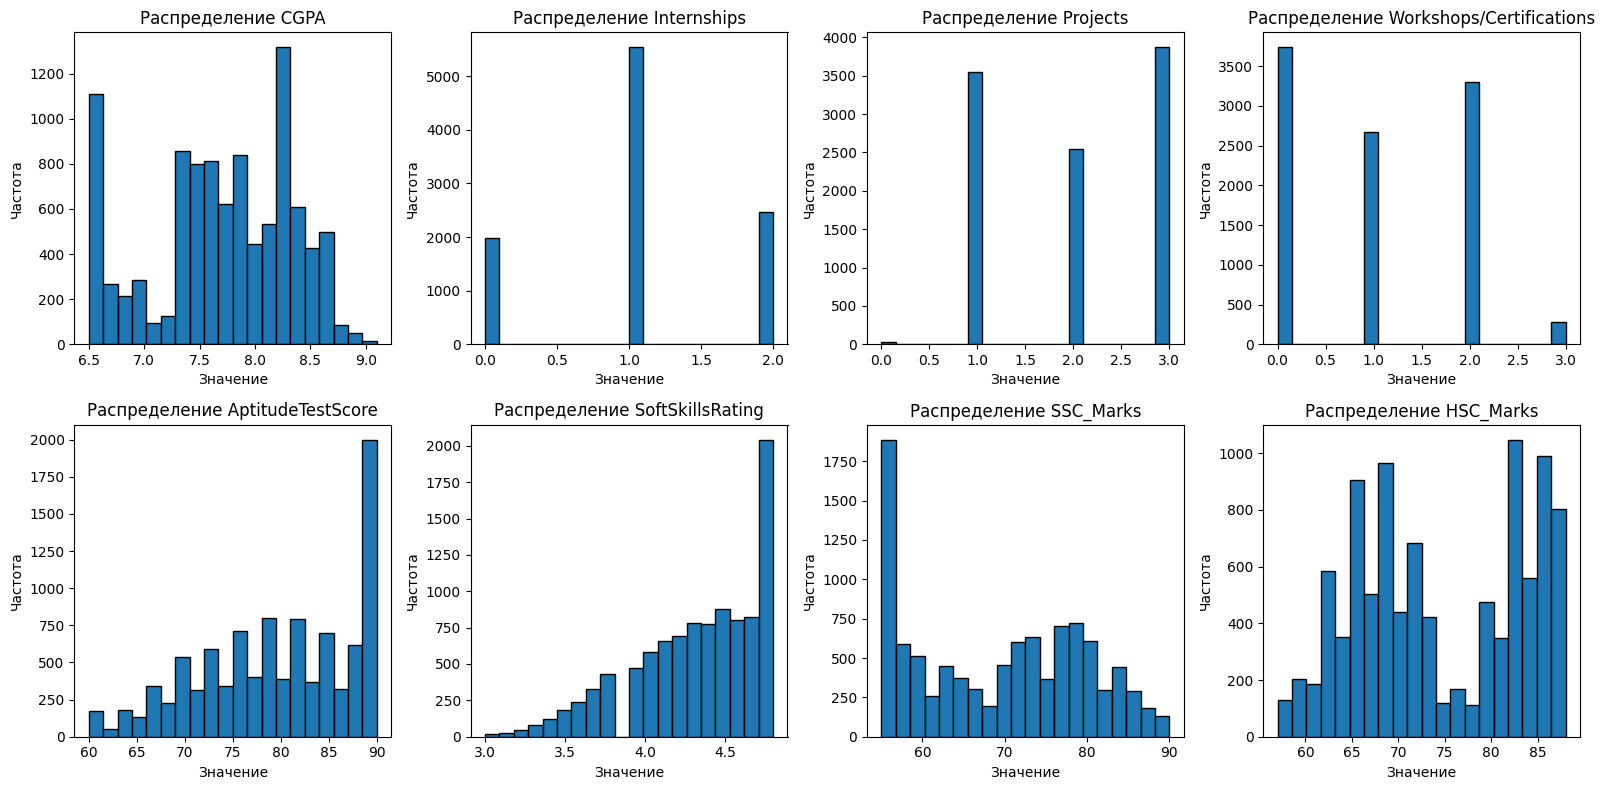

In [7]:
numeric_features = ['CGPA', 'Internships', 'Projects', 'Workshops/Certifications',
                   'AptitudeTestScore', 'SoftSkillsRating', 'SSC_Marks', 'HSC_Marks']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.ravel()

for i, col in enumerate(numeric_features):
    axes[i].hist(df[col], bins=20, edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()

У переменных значения в разных диапазона. Понадобится стабилизация

Целевая переменная — PlacementStatus, указывающая, был ли студент трудоустроен. Есть дисбаланс классов

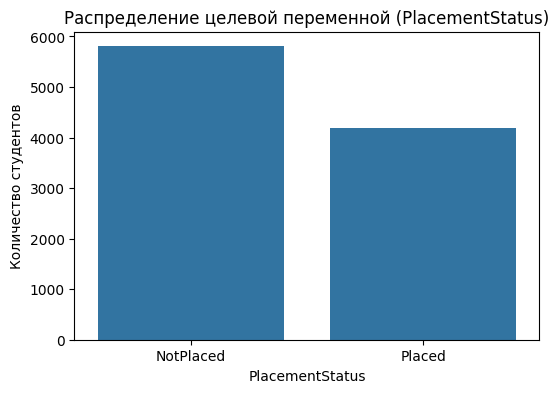

In [8]:
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='PlacementStatus')
plt.title('Распределение целевой переменной (PlacementStatus)')
plt.ylabel('Количество студентов')
plt.show()

Корреляция числовых признаков с целевой переменной

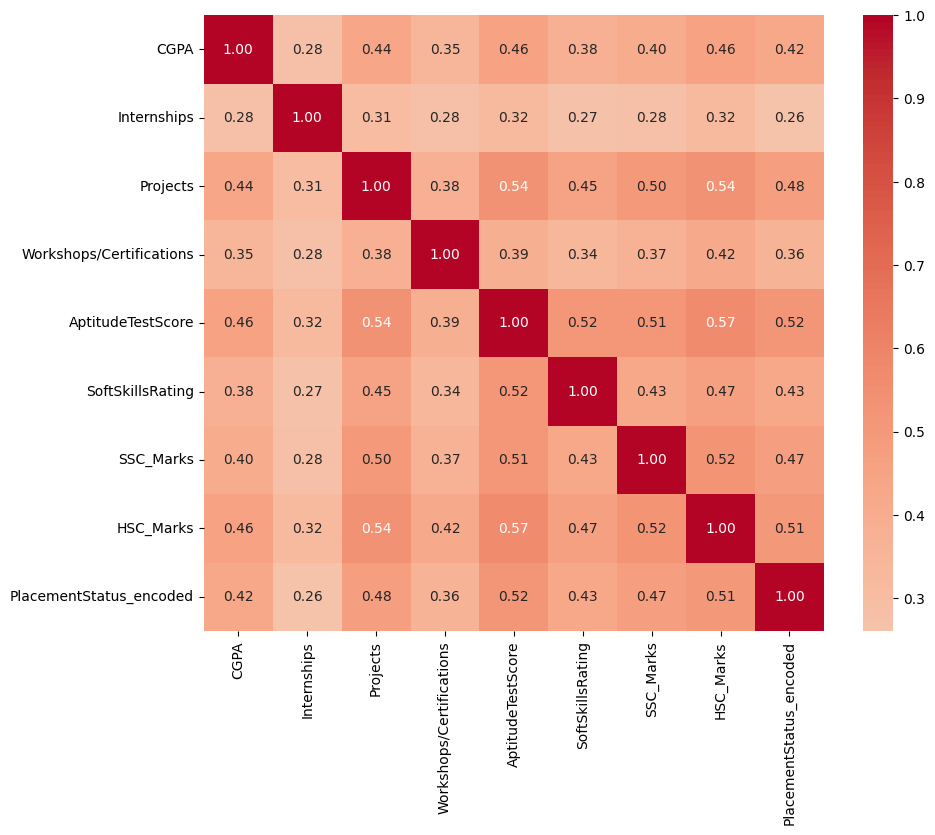

In [9]:
df_corr = df.copy()
df_corr['PlacementStatus_encoded'] = df_corr['PlacementStatus'].map({'NotPlaced': 0, 'Placed': 1})

numeric_cols_for_corr = numeric_features + ['PlacementStatus_encoded']
correlation_matrix = df_corr[numeric_cols_for_corr].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

По тепловой карте наибольшую корреляцию имеют признаки AptitudeTestScore (0.52), HSC_Marks (0.51), Projects (0.48), SoftSkillsRating (0.43), CGPA (0.42)

##Бейзлайн библиотечной модели

Загрузка библиотек

In [10]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [11]:
df_processed = df.copy()

Кодирование бинарных признаков и целевой переменной

In [12]:
binary_columns = ['ExtracurricularActivities', 'PlacementTraining']
for col in binary_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

In [13]:
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df_processed['PlacementStatus'])
X = df_processed.drop(columns=['StudentID', 'PlacementStatus'])

Разделение на выборки

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Обучение бейзлайна

In [15]:
knn_baseline = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='auto')
knn_baseline.fit(X_train, y_train)


KNeighborsClassifier()

In [16]:
y_pred_baseline = knn_baseline.predict(X_test)

Оценка модели

In [17]:
print(classification_report(y_test, y_pred_baseline, target_names=target_encoder.classes_))

              precision    recall  f1-score   support

   NotPlaced       0.79      0.81      0.80      1161
      Placed       0.73      0.70      0.71       839

    accuracy                           0.77      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.77      0.76      2000



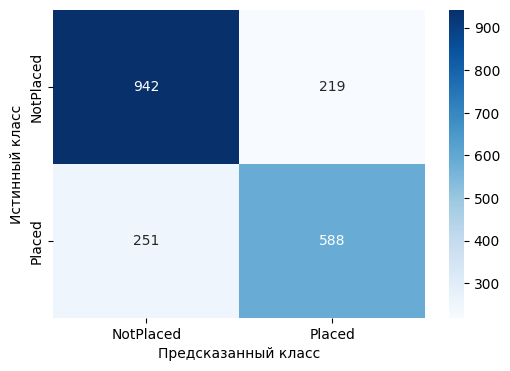

In [18]:
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_baseline, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()


In [19]:
from sklearn.metrics import f1_score
f1_per_class_baseline = f1_score(y_test, y_pred_baseline, average=None, labels=[0, 1])
f1_micro_baseline = f1_score(y_test, y_pred_baseline, average='micro')
f1_macro_baseline = f1_score(y_test, y_pred_baseline, average='macro')

##Улучшение бейзлайна

In [28]:
df_processed = df.copy()
binary_columns = ['ExtracurricularActivities', 'PlacementTraining']
for col in binary_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

target_encoder = LabelEncoder()
y = target_encoder.fit_transform(df_processed['PlacementStatus'])
X = df_processed.drop(columns=['StudentID', 'PlacementStatus'])

Формирование нового признака, который объединяет активности студента. Это поможет уменьшить количество признаков. Гипотеза: активности сильно влияют на трудоустройство

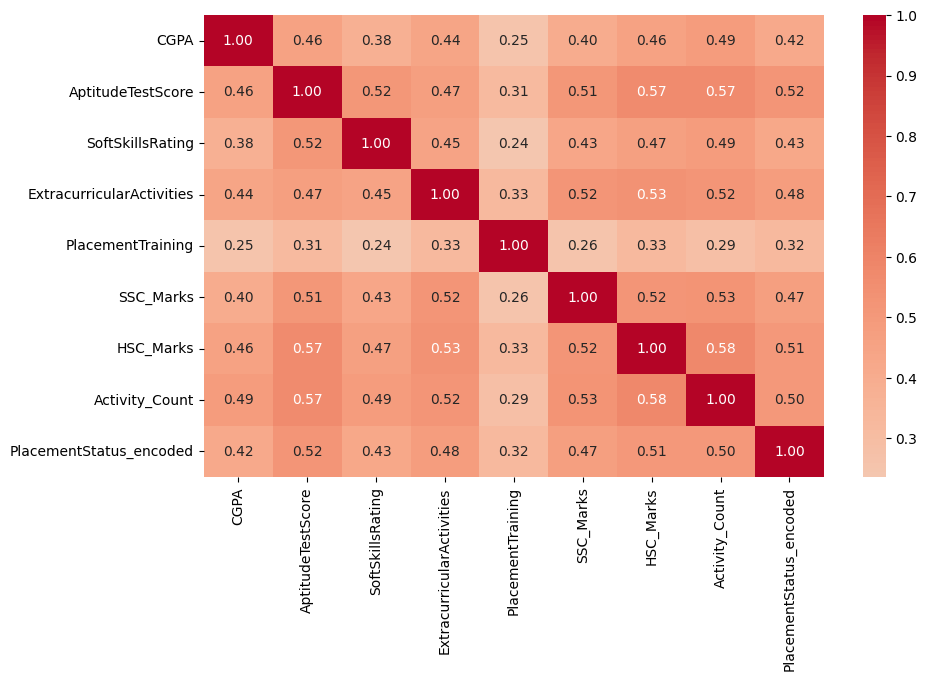

In [29]:
X_enhanced = X.copy()
X_enhanced['Activity_Count'] = X_enhanced['Projects'] + X_enhanced['Internships'] + X_enhanced['Workshops/Certifications']
X_enhanced = X_enhanced.drop(columns=['Projects', 'Internships', 'Workshops/Certifications'])

df_corr_enhanced = X_enhanced.copy()
df_corr_enhanced['PlacementStatus_encoded'] = y
correlation_with_target = df_corr_enhanced.corr()['PlacementStatus_encoded'].drop('PlacementStatus_encoded').sort_values(key=abs, ascending=False)

plt.figure(figsize=(10, 6))
sns.heatmap(df_corr_enhanced.corr(), annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

In [30]:
print("Корреляция признаков с целевой переменной (улучшенный набор):")
print(correlation_with_target)

Корреляция признаков с целевой переменной (улучшенный набор):
AptitudeTestScore            0.521744
HSC_Marks                    0.505746
Activity_Count               0.502715
ExtracurricularActivities    0.482491
SSC_Marks                    0.469763
SoftSkillsRating             0.427284
CGPA                         0.423131
PlacementTraining            0.323659
Name: PlacementStatus_encoded, dtype: float64


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)

Стандартизация полезна, так как алгоритм KNN чувствителен к разным масштабам данных

In [32]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

 Подбор гиперпараметров

In [33]:
param_grid = {
    'n_neighbors': list(range(1, 21, 2)),
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_knn_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

Лучшие параметры: {'n_neighbors': 19, 'weights': 'uniform'}


F1-мера для класса 'NotPlaced' (0): 0.8267
F1-мера для класса 'Placed' (1): 0.7565
Микро-усредненная F1-мера: 0.7975
Макро-усредненная F1-мера: 0.7916


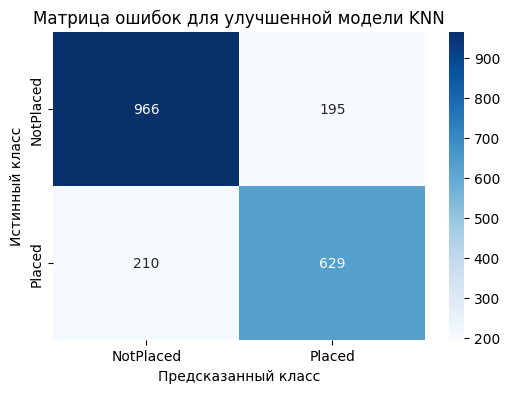

In [34]:
y_pred_improved = best_knn_model.predict(X_test_scaled)

accuracy_improved = accuracy_score(y_test, y_pred_improved)
f1_per_class_improved = f1_score(y_test, y_pred_improved, average=None, labels=[0, 1])
f1_micro_improved = f1_score(y_test, y_pred_improved, average='micro')
f1_macro_improved = f1_score(y_test, y_pred_improved, average='macro')

print(f"F1-мера для класса 'NotPlaced' (0): {f1_per_class_improved[0]:.4f}")
print(f"F1-мера для класса 'Placed' (1): {f1_per_class_improved[1]:.4f}")
print(f"Микро-усредненная F1-мера: {f1_micro_improved:.4f}")
print(f"Макро-усредненная F1-мера: {f1_macro_improved:.4f}")

cm_improved = confusion_matrix(y_test, y_pred_improved)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_improved, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.title('Матрица ошибок для улучшенной модели KNN')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

##Сравнение

По результатам сравнения метрик можно сделать вывод, что стандартизация и объединение признаков улучшили предсказание модели

In [35]:
comparison_df = pd.DataFrame({
    'Метрика': ['F1-NotPlaced', 'F1-Placed', 'F1-Micro', 'F1-Macro'],
    'Бейзлайн': [f1_per_class_baseline[0], f1_per_class_baseline[1], f1_micro_baseline, f1_macro_baseline],
    'Улучшенный': [f1_per_class_improved[0], f1_per_class_improved[1], f1_micro_improved, f1_macro_improved]
})

print("\n--- Сравнение результатов ---")
print(comparison_df.round(4))


--- Сравнение результатов ---
        Метрика  Бейзлайн  Улучшенный
0  F1-NotPlaced    0.8003      0.8267
1     F1-Placed    0.7145      0.7565
2      F1-Micro    0.7650      0.7975
3      F1-Macro    0.7574      0.7916


##Имплементация алгоритма машинного обучения

F1-мера для класса 'NotPlaced' (0): 0.8003
F1-мера для класса 'Placed' (1): 0.7145
Микро-усредненная F1-мера: 0.7650
Макро-усредненная F1-мера: 0.7574
              precision    recall  f1-score   support

   NotPlaced       0.79      0.81      0.80      1161
      Placed       0.73      0.70      0.71       839

    accuracy                           0.77      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.77      0.76      2000



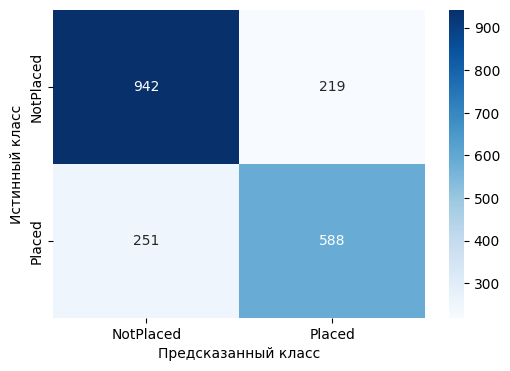

In [37]:
df_processed = df.copy()

binary_columns = ['ExtracurricularActivities', 'PlacementTraining']
for col in binary_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

target_encoder = LabelEncoder()
df_processed['PlacementStatus'] = target_encoder.fit_transform(df_processed['PlacementStatus'])

X = df_processed.drop(columns=['StudentID', 'PlacementStatus'])
y = df_processed['PlacementStatus']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

class CustomKNN_Baseline:
    def __init__(self, k=5, weights='uniform'):
        self.k = k
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y, dtype=np.int64)

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def predict(self, X_test):
        X_test = np.array(X_test, dtype=np.float64)
        predictions = []
        for test_point in X_test:

            distances = [self._euclidean_distance(test_point, train_point) for train_point in self.X_train]

            k_indices = np.argsort(distances)[:self.k]

            k_nearest_labels = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            if self.weights == 'uniform':

                prediction = max(set(k_nearest_labels), key=list(k_nearest_labels).count)

            elif self.weights == 'distance':

                weights = 1 / (k_distances + 1e-8)

                unique_labels = np.unique(k_nearest_labels)
                weighted_votes = {}
                for label in unique_labels:
                    mask = k_nearest_labels == label
                    weighted_votes[label] = np.sum(weights[mask])

                prediction = max(weighted_votes, key=weighted_votes.get)

            predictions.append(prediction)
        return np.array(predictions)

custom_knn_baseline = CustomKNN_Baseline(k=5, weights='uniform')
custom_knn_baseline.fit(X_train, y_train)

y_pred_custom_baseline = custom_knn_baseline.predict(X_test)

accuracy_custom_baseline = accuracy_score(y_test, y_pred_custom_baseline)
f1_per_class_custom_baseline = f1_score(y_test, y_pred_custom_baseline, average=None, labels=[0, 1])
f1_micro_custom_baseline = f1_score(y_test, y_pred_custom_baseline, average='micro')
f1_macro_custom_baseline = f1_score(y_test, y_pred_custom_baseline, average='macro')

print(f"F1-мера для класса 'NotPlaced' (0): {f1_per_class_custom_baseline[0]:.4f}")
print(f"F1-мера для класса 'Placed' (1): {f1_per_class_custom_baseline[1]:.4f}")
print(f"Микро-усредненная F1-мера: {f1_micro_custom_baseline:.4f}")
print(f"Макро-усредненная F1-мера: {f1_macro_custom_baseline:.4f}")

print(classification_report(y_test, y_pred_custom_baseline, target_names=target_encoder.classes_))

cm_custom_baseline = confusion_matrix(y_test, y_pred_custom_baseline)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_custom_baseline, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

##Улучшение

F1-мера для класса 'NotPlaced' (0): 0.8140
F1-мера для класса 'Placed' (1): 0.7381
Микро-усредненная F1-мера: 0.7825
Макро-усредненная F1-мера: 0.7761
              precision    recall  f1-score   support

   NotPlaced       0.81      0.82      0.81      1161
      Placed       0.75      0.73      0.74       839

    accuracy                           0.78      2000
   macro avg       0.78      0.78      0.78      2000
weighted avg       0.78      0.78      0.78      2000



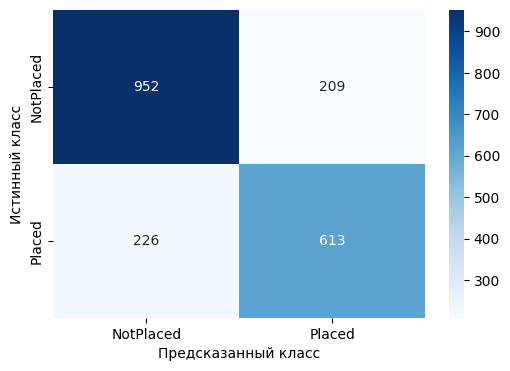

In [38]:
df_processed = df.copy()

binary_columns = ['ExtracurricularActivities', 'PlacementTraining']
for col in binary_columns:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])

target_encoder = LabelEncoder()
df_processed['PlacementStatus'] = target_encoder.fit_transform(df_processed['PlacementStatus'])

X = df_processed.drop(columns=['StudentID', 'PlacementStatus'])
y = df_processed['PlacementStatus']

X_enhanced = X.copy()
X_enhanced['Activity_Count'] = X_enhanced['Projects'] + X_enhanced['Internships'] + X_enhanced['Workshops/Certifications']
X_enhanced = X_enhanced.drop(columns=['Projects', 'Internships', 'Workshops/Certifications'])

X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class CustomKNN_Enhanced:
    def __init__(self, k=5, weights='uniform'):
        self.k = k
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = np.array(X, dtype=np.float64)
        self.y_train = np.array(y, dtype=np.int64)

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def predict(self, X_test):
        X_test = np.array(X_test, dtype=np.float64)
        predictions = []
        for test_point in X_test:
            distances = [self._euclidean_distance(test_point, train_point) for train_point in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_labels = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            if self.weights == 'uniform':
                prediction = max(set(k_nearest_labels), key=list(k_nearest_labels).count)
            elif self.weights == 'distance':
                weights = 1 / (k_distances + 1e-8)
                unique_labels = np.unique(k_nearest_labels)
                weighted_votes = {}
                for label in unique_labels:
                    mask = k_nearest_labels == label
                    weighted_votes[label] = np.sum(weights[mask])
                prediction = max(weighted_votes, key=weighted_votes.get)

            predictions.append(prediction)
        return np.array(predictions)

custom_knn_enhanced = CustomKNN_Enhanced(k=5, weights='uniform')
custom_knn_enhanced.fit(X_train_scaled, y_train)

y_pred_custom_enhanced = custom_knn_enhanced.predict(X_test_scaled)

accuracy_custom_enhanced = accuracy_score(y_test, y_pred_custom_enhanced)
f1_per_class_custom_enhanced = f1_score(y_test, y_pred_custom_enhanced, average=None, labels=[0, 1])
f1_micro_custom_enhanced = f1_score(y_test, y_pred_custom_enhanced, average='micro')
f1_macro_custom_enhanced = f1_score(y_test, y_pred_custom_enhanced, average='macro')

print(f"F1-мера для класса 'NotPlaced' (0): {f1_per_class_custom_enhanced[0]:.4f}")
print(f"F1-мера для класса 'Placed' (1): {f1_per_class_custom_enhanced[1]:.4f}")
print(f"Микро-усредненная F1-мера: {f1_micro_custom_enhanced:.4f}")
print(f"Макро-усредненная F1-мера: {f1_macro_custom_enhanced:.4f}")

print(classification_report(y_test, y_pred_custom_enhanced, target_names=target_encoder.classes_))

cm_custom_enhanced = confusion_matrix(y_test, y_pred_custom_enhanced)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_custom_enhanced, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

#Общее сравнение

Можно сделать вывод, что дополнительные техники способствуют улучшению качества модели

In [42]:
comparison_results = {
    'Модель': [
        'Библиотечный KNN (бейзлайн)',
        'Библиотечный KNN (улучшенный)',
        'Имплементированный KNN (бейзлайн)',
        'Имплементированный KNN (улучшенный)'
    ],

    'F1-мера (NotPlaced)': [
        f1_per_class_baseline[0],
        f1_per_class_improved[0],
        f1_per_class_custom_baseline[0],
        f1_per_class_custom_enhanced[0]
    ],
    'F1-мера (Placed)': [
        f1_per_class_baseline[1],
        f1_per_class_improved[1],
        f1_per_class_custom_baseline[1],
        f1_per_class_custom_enhanced[1]
    ],
    'F1-микро': [
        f1_micro_baseline,
        f1_micro_improved,
        f1_micro_custom_baseline,
        f1_micro_custom_enhanced
    ],
    'F1-макро': [
        f1_macro_baseline,
        f1_macro_improved,
        f1_macro_custom_baseline,
        f1_macro_custom_enhanced
    ]
}

print("\nСравнение по F1")
f1_comparison = pd.DataFrame(comparison_results)[['Модель', 'F1-мера (NotPlaced)']].sort_values(by='F1-мера (NotPlaced)', ascending=False)
print(f1_comparison)


Сравнение по F1
                                Модель  F1-мера (NotPlaced)
1        Библиотечный KNN (улучшенный)             0.826701
3  Имплементированный KNN (улучшенный)             0.814023
0          Библиотечный KNN (бейзлайн)             0.800340
2    Имплементированный KNN (бейзлайн)             0.800340


#Регрессия

Задача - предсказать длину тела австралийской куницы по другим морфометрическим признакам. Это полезно для биологов и экологов, занимающихся изучением популяций, биометрией и охраной природы.

В такой задаче важны метрики R²  и MAE. RMSE — чувствительна к выбросам, полезна для сравнения моделей.

##Исследование датасета

In [43]:
df = pd.read_csv('possum.csv')

In [44]:
print("Размер датасета:", df.shape)

Размер датасета: (104, 14)


In [45]:
print(df.head())

   case  site  Pop sex  age  hdlngth  skullw  totlngth  taill  footlgth  \
0     1     1  Vic   m  8.0     94.1    60.4      89.0   36.0      74.5   
1     2     1  Vic   f  6.0     92.5    57.6      91.5   36.5      72.5   
2     3     1  Vic   f  6.0     94.0    60.0      95.5   39.0      75.4   
3     4     1  Vic   f  6.0     93.2    57.1      92.0   38.0      76.1   
4     5     1  Vic   f  2.0     91.5    56.3      85.5   36.0      71.0   

   earconch   eye  chest  belly  
0      54.5  15.2   28.0   36.0  
1      51.2  16.0   28.5   33.0  
2      51.9  15.5   30.0   34.0  
3      52.2  15.2   28.0   34.0  
4      53.2  15.1   28.5   33.0  


In [46]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   case      104 non-null    int64  
 1   site      104 non-null    int64  
 2   Pop       104 non-null    object 
 3   sex       104 non-null    object 
 4   age       102 non-null    float64
 5   hdlngth   104 non-null    float64
 6   skullw    104 non-null    float64
 7   totlngth  104 non-null    float64
 8   taill     104 non-null    float64
 9   footlgth  103 non-null    float64
 10  earconch  104 non-null    float64
 11  eye       104 non-null    float64
 12  chest     104 non-null    float64
 13  belly     104 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 11.5+ KB
None


In [47]:
print(df.describe())

             case        site         age     hdlngth      skullw    totlngth  \
count  104.000000  104.000000  102.000000  104.000000  104.000000  104.000000   
mean    52.500000    3.625000    3.833333   92.602885   56.883654   87.088462   
std     30.166206    2.349086    1.909244    3.573349    3.113426    4.310549   
min      1.000000    1.000000    1.000000   82.500000   50.000000   75.000000   
25%     26.750000    1.000000    2.250000   90.675000   54.975000   84.000000   
50%     52.500000    3.000000    3.000000   92.800000   56.350000   88.000000   
75%     78.250000    6.000000    5.000000   94.725000   58.100000   90.000000   
max    104.000000    7.000000    9.000000  103.100000   68.600000   96.500000   

            taill    footlgth    earconch         eye       chest       belly  
count  104.000000  103.000000  104.000000  104.000000  104.000000  104.000000  
mean    37.009615   68.459223   48.130769   15.046154   27.000000   32.586538  
std      1.959518    4.395306 

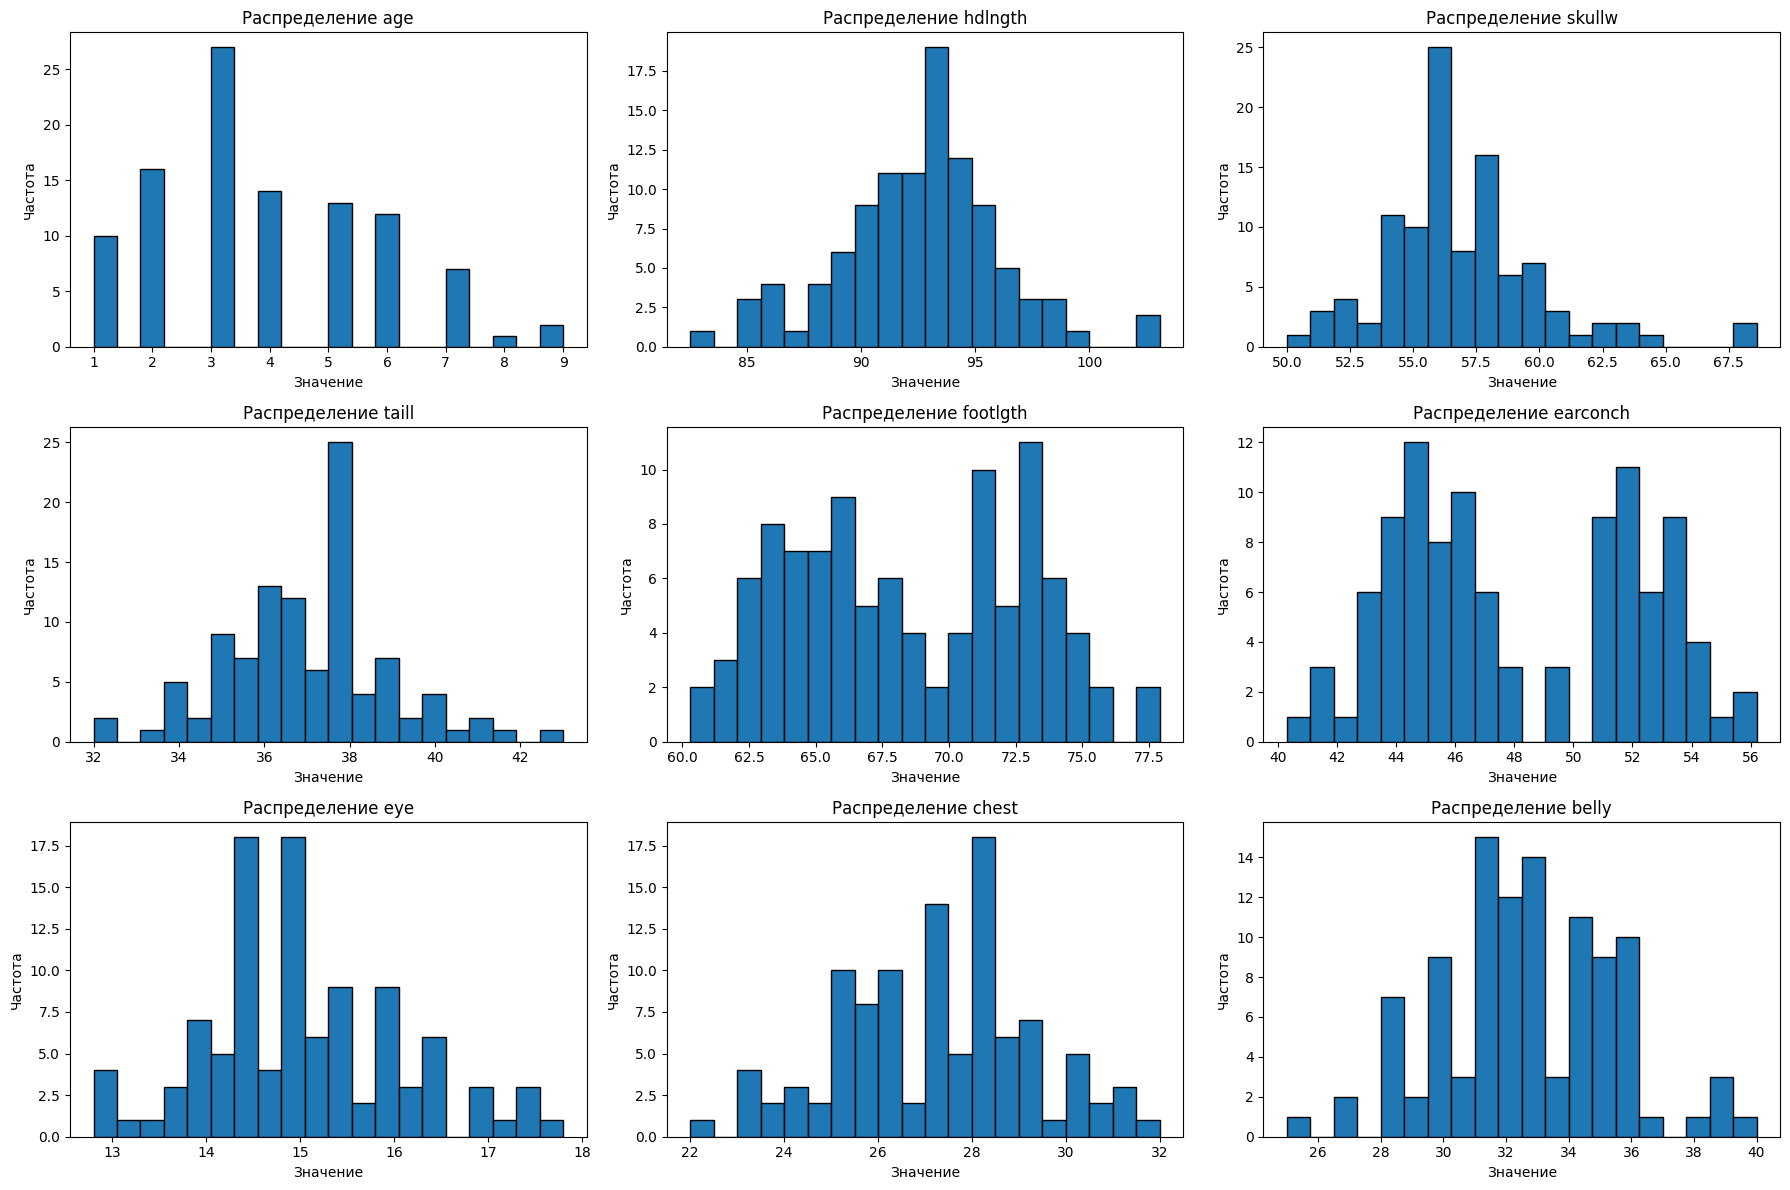

In [48]:
numeric_features = ['age', 'hdlngth', 'skullw', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_features):
    axes[i].hist(df[col], bins=20, edgecolor='black')
    axes[i].set_title(f'Распределение {col}')
    axes[i].set_xlabel('Значение')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()


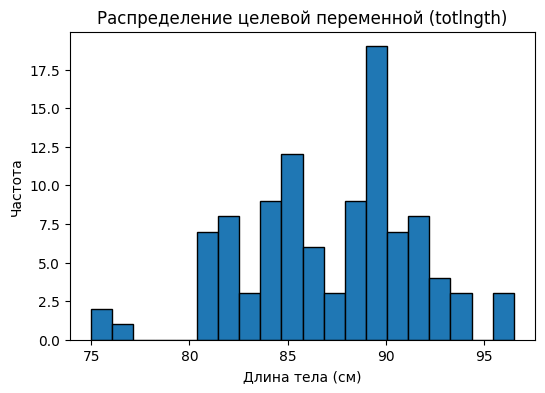

In [49]:
plt.figure(figsize=(6, 4))
plt.hist(df['totlngth'], bins=20, edgecolor='black')
plt.title('Распределение целевой переменной (totlngth)')
plt.xlabel('Длина тела (см)')
plt.ylabel('Частота')
plt.show()

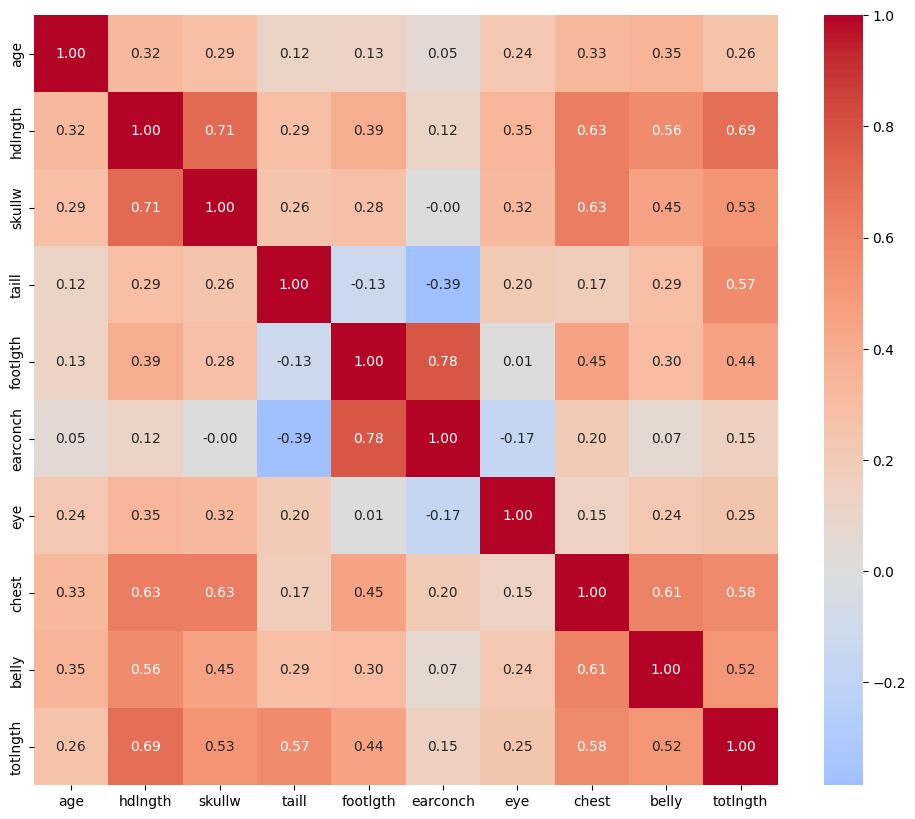

In [50]:
df_corr = df.copy()
numeric_cols_for_corr = numeric_features + ['totlngth']
correlation_matrix = df_corr[numeric_cols_for_corr].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.show()

Наиболее сильная корреляция с признаками hdlngth, chest, belly, skullw. Самая слабая корреляия с признаками eye и earconch

## Бейзлайн библиотечной модели

In [53]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv('possum.csv')

df = df.dropna().reset_index(drop=True)

X = df.drop(columns=['totlngth', 'case'])
y = df['totlngth']

X = X.copy()
le_site = LabelEncoder()
X['site'] = le_site.fit_transform(X['site'])

le_pop = LabelEncoder()
X['Pop'] = le_pop.fit_transform(X['Pop'])

le_sex = LabelEncoder()
X['sex'] = le_sex.fit_transform(X['sex'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)

r2_knn_no_prep = r2_score(y_test, y_pred_knn)
mae_knn_no_prep = mean_absolute_error(y_test, y_pred_knn)
rmse_knn_no_prep = np.sqrt(mean_squared_error(y_test, y_pred_knn))

def evaluate_model(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"--- {model_name} ---")
    print(f"R²: {r2:.3f}")
    print(f"MAE: {mae:.3f} см")
    print(f"RMSE: {rmse:.3f} см")

evaluate_model(y_test, y_pred_knn, "KNN-регрессия")

--- KNN-регрессия ---
R²: 0.370
MAE: 2.159 см
RMSE: 2.876 см


##Улучшенный бейзлайн

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

df = pd.read_csv('possum.csv')
df = df.dropna().reset_index(drop=True)

X = df.drop(columns=['totlngth', 'case'])
y = df['totlngth']

num_features = ['age', 'hdlngth', 'skullw', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
cat_features = ['site', 'Pop', 'sex']

Создание нового признака

In [55]:
X_enhanced = X.copy()
X_enhanced['Body_Size'] = X_enhanced['chest'] + X_enhanced['belly']
X_enhanced = X_enhanced.drop(columns=['chest', 'belly'])

Кодирование категориальных признаков

In [56]:
le_site = LabelEncoder()
X_enhanced['site'] = le_site.fit_transform(X_enhanced['site'])

le_pop = LabelEncoder()
X_enhanced['Pop'] = le_pop.fit_transform(X_enhanced['Pop'])

le_sex = LabelEncoder()
X_enhanced['sex'] = le_sex.fit_transform(X_enhanced['sex'])

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_enhanced, y, test_size=0.2, random_state=42)

all_features = ['age', 'hdlngth', 'skullw', 'taill', 'footlgth', 'earconch', 'eye', 'Body_Size', 'site', 'Pop', 'sex']

Использование препроцессора, пайплайна и подбора гиперпараметров

In [58]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), all_features)
    ]
)

knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', KNeighborsRegressor())
])

param_grid_knn = {
    'regressor__n_neighbors': range(1, 21, 2),
    'regressor__weights': ['uniform', 'distance']
}

grid_search_knn = GridSearchCV(knn_pipeline, param_grid_knn, cv=5, scoring='r2', n_jobs=-1)
grid_search_knn.fit(X_train, y_train)

best_knn_model = grid_search_knn.best_estimator_
print(f"Лучшие параметры для KNN: {grid_search_knn.best_params_}")

y_pred_knn_improved = best_knn_model.predict(X_test)

r2_knn_improved = r2_score(y_test, y_pred_knn_improved)
mae_knn_improved = mean_absolute_error(y_test, y_pred_knn_improved)
rmse_knn_improved = np.sqrt(mean_squared_error(y_test, y_pred_knn_improved))

print(f"R² (KNN улучшенный): {r2_knn_improved:.3f}")
print(f"MAE (KNN улучшенный): {mae_knn_improved:.3f} см")
print(f"RMSE (KNN улучшенный): {rmse_knn_improved:.3f} см")

r2_knn_improved = r2_knn_improved
mae_knn_improved = mae_knn_improved
rmse_knn_improved = rmse_knn_improved

Лучшие параметры для KNN: {'regressor__n_neighbors': 9, 'regressor__weights': 'distance'}
R² (KNN улучшенный): 0.509
MAE (KNN улучшенный): 2.181 см
RMSE (KNN улучшенный): 2.539 см


## Имплементация алгоритма машинного обучения

In [60]:
df_processed = df.copy()

X = df_processed.drop(columns=['totlngth', 'case'])
y = df_processed['totlngth']

num_features = ['age', 'hdlngth', 'skullw', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
cat_features = ['site', 'Pop', 'sex']

X_processed = pd.get_dummies(X, columns=cat_features, drop_first=True)

X_processed = X_processed.fillna(0)
X_processed = X_processed.apply(pd.to_numeric, errors='coerce').fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X_processed.values, y.values, test_size=0.2, random_state=42)

def standardize(X_train, X_test):
    X_train = X_train.astype(np.float64)
    X_test = X_test.astype(np.float64)

    mean = X_train.mean(axis=0)
    std = X_train.std(axis=0, ddof=0)
    X_train_scaled = (X_train - mean) / std
    X_test_scaled = (X_test - mean) / std
    return X_train_scaled, X_test_scaled

X_train_scaled, X_test_scaled = standardize(X_train, X_test)

class CustomKNN_Baseline:
    def __init__(self, k=5, weights='uniform'):
        self.k = k
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = [self._euclidean_distance(test_point, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_targets = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            if self.weights == 'uniform':
                prediction = np.mean(k_nearest_targets)
            elif self.weights == 'distance':
                weights = 1 / (k_distances + 1e-8)
                prediction = np.average(k_nearest_targets, weights=weights)

            predictions.append(prediction)
        return np.array(predictions)

custom_knn_baseline = CustomKNN_Baseline(k=6, weights='uniform')
custom_knn_baseline.fit(X_train_scaled, y_train)

y_pred_custom_baseline = custom_knn_baseline.predict(X_test_scaled)

r2_custom_baseline = r2_score(y_test, y_pred_custom_baseline)
mae_custom_baseline = mean_absolute_error(y_test, y_pred_custom_baseline)
rmse_custom_baseline = np.sqrt(mean_squared_error(y_test, y_pred_custom_baseline))

print(f"R² (Custom KNN бейзлайн): {r2_custom_baseline:.3f}")
print(f"MAE (Custom KNN бейзлайн): {mae_custom_baseline:.3f} см")
print(f"RMSE (Custom KNN бейзлайн): {rmse_custom_baseline:.3f} см")

R² (Custom KNN бейзлайн): 0.431
MAE (Custom KNN бейзлайн): 2.085 см
RMSE (Custom KNN бейзлайн): 2.510 см


##Улучшение

Применено кодирование категориальных признаков, формирование нового признака, стандартизация

In [64]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

df = pd.read_csv('possum.csv')
df_processed = df.copy()

X = df_processed.drop(columns=['totlngth', 'case'])
y = df_processed['totlngth']

num_features = ['age', 'hdlngth', 'skullw', 'taill', 'footlgth', 'earconch', 'eye', 'chest', 'belly']
cat_features = ['site', 'Pop', 'sex']

X_processed = pd.get_dummies(X, columns=cat_features, drop_first=True)

X_enhanced = X_processed.copy()
X_enhanced['Body_Size'] = X_enhanced['chest'] + X_enhanced['belly']
X_enhanced = X_enhanced.drop(columns=['chest', 'belly'])

X_train, X_test, y_train, y_test = train_test_split(X_enhanced.values, y.values, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

class CustomKNN_Enhanced:
    def __init__(self, k=5, weights='uniform'):
        self.k = k
        self.weights = weights
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _euclidean_distance(self, point1, point2):
        return np.sqrt(np.sum((point1 - point2) ** 2))

    def predict(self, X_test):
        predictions = []
        for test_point in X_test:
            distances = [self._euclidean_distance(test_point, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.k]
            k_nearest_targets = self.y_train[k_indices]
            k_distances = np.array(distances)[k_indices]

            if self.weights == 'uniform':
                prediction = np.mean(k_nearest_targets)
            elif self.weights == 'distance':
                weights = 1 / (k_distances + 1e-8)
                prediction = np.average(k_nearest_targets, weights=weights)

            predictions.append(prediction)
        return np.array(predictions)

custom_knn_enhanced = CustomKNN_Enhanced(k=6, weights='uniform')
custom_knn_enhanced.fit(X_train_scaled, y_train)

y_pred_custom_enhanced = custom_knn_enhanced.predict(X_test_scaled)

r2_custom_enhanced = r2_score(y_test, y_pred_custom_enhanced)
mae_custom_enhanced = mean_absolute_error(y_test, y_pred_custom_enhanced)
rmse_custom_enhanced = np.sqrt(mean_squared_error(y_test, y_pred_custom_enhanced))

print(f"R² (Custom KNN улучшенный): {r2_custom_enhanced:.3f}")
print(f"MAE (Custom KNN улучшенный): {mae_custom_enhanced:.3f} см")
print(f"RMSE (Custom KNN улучшенный): {rmse_custom_enhanced:.3f} см")

R² (Custom KNN улучшенный): 0.533
MAE (Custom KNN улучшенный): 1.914 см
RMSE (Custom KNN улучшенный): 2.273 см


#Сравнение

В данном случае стоит  учесть, что датасет маленький, поэтому обученный KNN может вести себя хуже на больших тестовых данных

In [67]:
comparison_results = {
    'Модель': [
        'Библиотечный KNN (бейзлайн)',
        'Библиотечный KNN (улучшенный)',
        'Имплементированный KNN (бейзлайн)',
        'Имплементированный KNN (улучшенный)'
    ],
    'R²': [
        r2_knn_no_prep,
        r2_knn_improved,
        r2_custom_baseline,
        r2_custom_enhanced
    ],
    'MAE': [
        mae_knn_no_prep ,
        mae_knn_improved,
        mae_custom_baseline,
        mae_custom_enhanced
    ],
    'RMSE': [
        rmse_knn_no_prep,
        rmse_knn_improved,
        rmse_custom_baseline,
        rmse_custom_enhanced
    ]
}

comparison_df_final = pd.DataFrame(comparison_results)
print("\nСравнение по метрикам")
print(comparison_df_final.round(3))


Сравнение по метрикам
                                Модель     R²    MAE   RMSE
0          Библиотечный KNN (бейзлайн)  0.370  2.159  2.876
1        Библиотечный KNN (улучшенный)  0.509  2.181  2.539
2    Имплементированный KNN (бейзлайн)  0.431  2.085  2.510
3  Имплементированный KNN (улучшенный)  0.533  1.914  2.273
